# Home Assignment No. 2: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1.1. Boosting, part 1. (2 points)


> Boosting Machines (BM) are a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: firstly we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is acheived by reweighting the training samples during each algorithm's step. 

#### The task:

In this exercise you will be asked to implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. The key steps are:

* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

The pseudocode for AdaBoost can be found in [Lecture 7](https://github.com/adasegroup/ML2020_lectures).

##### criteria

the decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit` :

$$
    |\text{your_accuracy} - \text{sklearn_accuracy}| \leq 0.04
\,. $$

#### Place for ypur solution

In [52]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

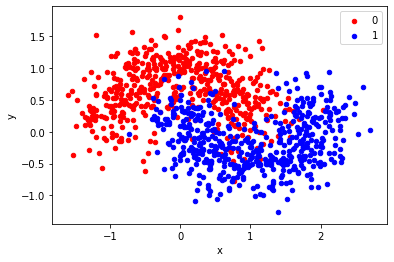

In [53]:
### Plot the dataset
from pandas import DataFrame

# plt.subplot(325)
# plt.title("moons", fontsize='small')
X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)
# plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
#             s=25, edgecolor='k')


df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()
# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

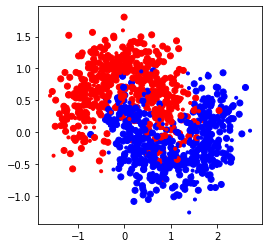

In [55]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)

base classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers
* `ada_boost_distribution` - function, which calculates sample weights

Implement htese procedures

In [57]:
### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm

def ada_boost_alpha(y, y_pred_t, distribution):
    """
    y_pred_t is a prediction of the t-th base classifier
    
    
    """
    summ = 0
    for i in range(len(y_pred_t)):
        summ+= distribution[i]*int(y[i]*y_pred_t[i]<=0)
    alpha = np.log((1-summ)/summ)/2
    return alpha

In [58]:
def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    y_pred_t is a prediction of the t-th base classifier
    
    """
    dist = []
    for i in range(len(y_pred_t)):
        w = distribution[i]*np.exp(-alpha_t*y_pred_t[i]*y[i])
#         summ = 0
#         for j in range(len(y_pred_t)):
#             summ += np.exp(-alpha_t*y_pred_t[j]*y[j])
        dist.append(w)
    distribution = dist
    return distribution

Our custom boosting class

In [59]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # ======= Your code here ======
            
            # make a prediction

            predict = self.classifiers[-1].predict(X)
            #update alphas, append new alpha to self.alphas
            alpha = ada_boost_alpha(y, predict, distribution)
            self.alphas.append(alpha)
             
            # update distribution and normalize
            distribution =  ada_boost_distribution(y, predict, distribution, alpha)/np.sum(ada_boost_distribution(y, predict, distribution, alpha))
            

    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        
        #print(self.alphas.shape)
        #print(self.class)
        final_predictions = np.sum([self.alphas[i]*self.classifiers[i].predict(X) for i in range(self.n_estimators)],axis=0)
#         out = np.sign(np.sum(final_predictions))
        out = np.sign(final_predictions)
        return out

In [60]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost1 = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost1.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [61]:
classifiers = [ada_boost1, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.875
accuracy ada_boost_sklearn: 0.875


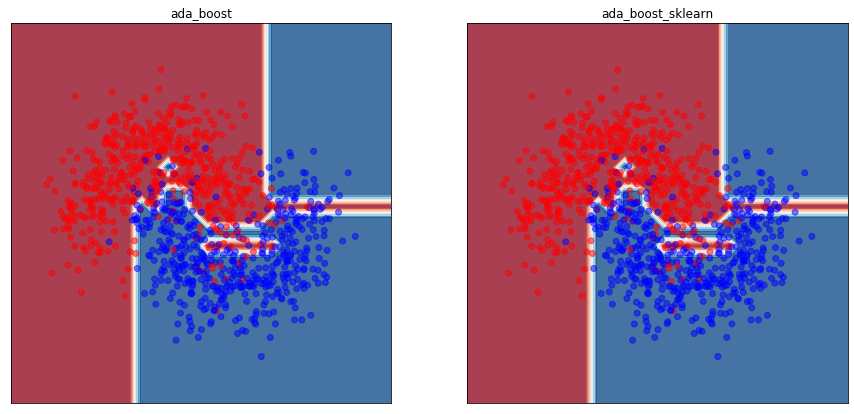

In [62]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

Our implementation has the same accuracy as sklearn implemantation

## Task 1.2. Boosting, part 2. (2 points)

For adaboost we have computed each alpha according to the formula:

$$\alpha_t = \frac{1}{2}\log{\frac{1-N_T(h_T, w_T )}{N_T(h_T,w_t)}}$$

In the next task you will be asked to instead recompute all of the alphas after adding another estimator to the composition of models, i.e. when the new classifier is fitted to the weighted data samples, the new alphas should be recomputed by directly minimizing the exponential loss, for all the avaliable estimators. Take into account, that at each step of the boosting algorithm **all** alphas and, consequntly, **all** sample weights should be recomputed from scratch. 

**The task**:
* Complete the `recompute_alpha` and `recompute_distribution` functions
* Complete the `.fit` method of `RecomputeBoosting` class
* Complete the `.predict` method of `RecomputeBoosting` class
* Plot the final alphas (last calculated in case of recomputed alphas)
* plot the history scores of the resulting model at each iteration (use ```predict```, ```score``` and ```construct_alpha_history``` functions defined below) for both RecomputedBoosting and AdaBoost (it can be either your own implementation from Exercise 1.1 or the one from sklearn - in this case use ```.estimator_weights_```, ```.estimators_```)
* Make a conclusion about which method is better and in which case - in order to do that you can additionally vary the parameters of training: number and depth of the estimators, noise of the data (moons)

**HINTS:**

In order to minimize the exponential loss with respect to alpha, use the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

When defining the function to minimize (in case of AdaBoost it should be the exponential loss), have a look at the optimization problem formulation of Ridge Regression and at the reguralization parameter([Lecture 2, slide 14](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture2/Lecture_2_Regression.pdf)). Add it in order to guarantee the existence of the solution.

In [63]:
from scipy.optimize import minimize

In [64]:

def recompute_alpha(y, y_pred, C):
    """
    y_pred - is a list of predictions of the existing estimators
    C - is a reguralization term    
    """
    # ====== Your code here =====
#     print(y.shape)
#     print(y_pred.shape)
    random_state =23
    fun = lambda alpha:  np.sum(np.exp(-y*(y_pred@alpha)))/y.shape[0]+C*np.linalg.norm(alpha)**2 
#     alphas = np.random.rand(np.size(y_pred,1))
    alphas = np.ones(y_pred.shape[1]) / y_pred.shape[1]
#     for i in range(len(y))
#         sum
#         for t in range(len(y_pred)):
#     alpha
    res =  minimize(fun, alphas, method ='CG')
    alphas = res.x
    return alphas
    

def recompute_distribution(y, y_pred, alphas):
    """
    y_pred - is a list of predictions of the existing estimators
    alphas - are the last recomputed alphas
    """

    # ====== Your code here =====
    n_points = np.size(y_pred,0)
    n_estimators = np.size(y_pred,1)
    dist = [1/n_points for i in range(n_points)]
    
    for t in range(n_estimators):
        dist_new = []
        for i in range(n_points):
            w = dist[i]*np.exp(-y_pred[i][:]@alphas[:n_estimators,t]*y[i])
            dist_new.append(w)
        nrm = sum(dist_new)
        dist = list(dist_new) / nrm
    
    return dist

In [65]:
class RecomputedBoosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=recompute_alpha, update_distribution=recompute_distribution, C=1.0):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = recompute_alpha
        self.update_distribution = recompute_distribution
        self.C = C
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        
        #notice how alpha is a matrix - we will store the history of the updates here
        self.alphas = np.zeros((n_estimators, n_estimators))
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())        
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            
            # ======= Your code here ======
            # create a list of predictions across all classifiers
            predict = np.array([self.classifiers[i].predict(X) for i in range(np.size(self.classifiers))]).T
            
            # recalculate alphas, add them to the matrix of self.alphas 
            # NOTE: here, self.alphas is a history of computed alphas at each step i
            self.alphas[0:np.size(self.classifiers),i] = self.get_alpha(y,predict,self.C)
            
            # update distribution and normalize
            distribution = self.update_distribution(y, predict, self.alphas)
            
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        #do not forget that self.alphas is the whole history of recalculated alphas!
        final_predictions = np.sign(np.sum([self.alphas[i,-1]*self.classifiers[i].predict(X) for i in range(self.n_estimators)],axis=0))
        
        return final_predictions
    
    

In [66]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators = 100
ada_boost = RecomputedBoosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                     update_distribution=recompute_distribution, C=1.0)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [67]:
classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.9
accuracy ada_boost_sklearn: 0.875


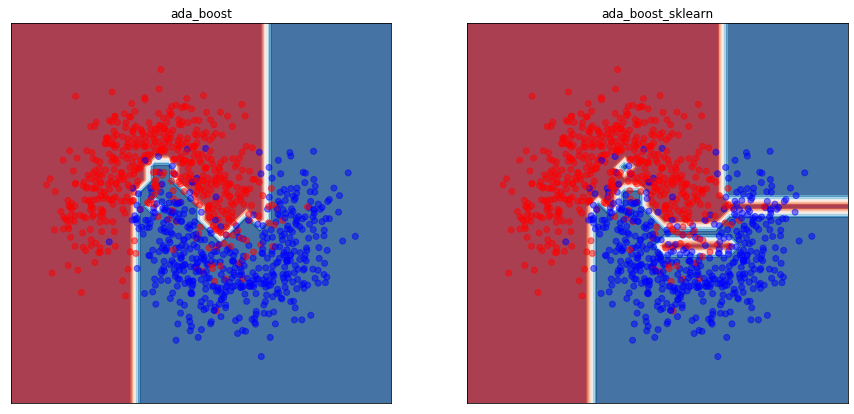

In [68]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

In [69]:
from sklearn.metrics import accuracy_score

def score(alphas, estimators, X, y):
    return accuracy_score(y, predict(alphas, estimators, X))

def predict(alphas, estimators, X, y=None):
    return np.sign(sum(
        b * e.predict(X) for b, e in zip(alphas, estimators)
    ))

def construct_alpha_history(init_alphas):
    """
    construct alpha history, alike recomputed alpha history, for AdaBoost algorithm
    """
    alphas = np.zeros((len(init_alphas), len(init_alphas)))
    for t, alpha in enumerate(init_alphas):
        alphas[t:, t] = alpha
    return alphas

In [70]:
## Plot the resulting alphas (last calculated in case of recomputed alphas)
scor =  score(ada_boost.alphas[:, -1], ada_boost.classifiers, X_test, y_test)
pred = predict(ada_boost.alphas[:, -1], ada_boost.classifiers, X_test, y_test)
cah = construct_alpha_history(ada_boost.alphas[:, -1])


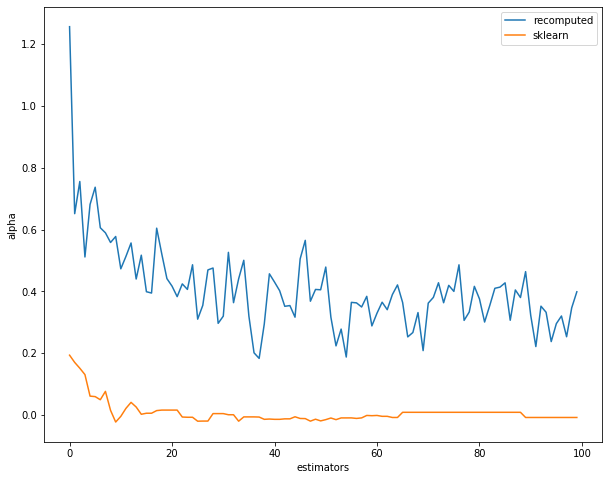

In [73]:
# plt.plot(ada_boost.alphas[-1,-1])
plt.figure(figsize = (10,8))
plt.plot(ada_boost1.alphas, label='recomputed')

plt.plot(ada_boost.alphas[:,-1], label = 'sklearn')
plt.xlabel('estimators')
plt.ylabel('alpha')
plt.legend()

In [75]:
sc_ada_boost, sc_recomputed_ada_boost = [], []
for it in range(np.size(ada_boost1.classifiers)):
    sc_ada_boost.append(score(ada_boost1.alphas[:it+1], ada_boost1.classifiers[:it+1], X_test, y_test))
    sc_recomputed_ada_boost.append(score(ada_boost.alphas[:,it], ada_boost.classifiers[:it+1], X_test, y_test))

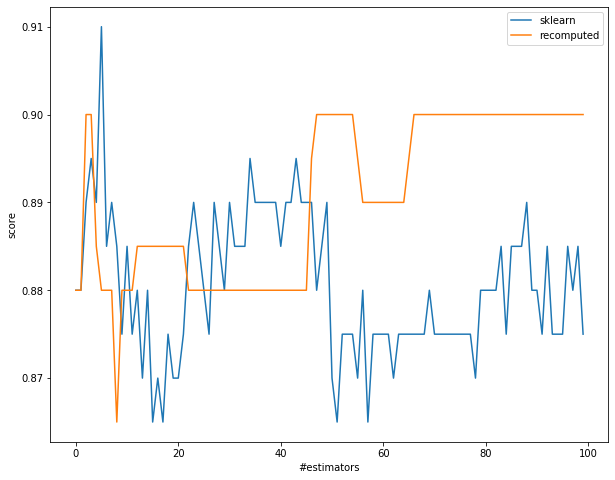

In [76]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
## for AdaBoost and RecomputedAdaBoost
plt.figure(figsize = (10,8))
plt.plot(sc_ada_boost, label = 'sklearn')
plt.plot(sc_recomputed_ada_boost,  label='recomputed')
plt.xlabel('#estimators')
plt.ylabel('score')
plt.legend()

In [254]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
## for AdaBoost and RecomputedAdaBoost

Make a conclusion about which method is better and in which case. 

Recomputed AdaBoost is more accurate, but it has some flaws: it is slower and it requires motre memory. On the conntrary, Sklearn AdaBoost is quick but not that precise

Your answer

## Task 2. Gradient Boosting and Feature Selection (1 point)

Gradient Boosting Machines (GBM) are a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are the extremely powerful tools, widely used in industry, research and various machine learning competitions. 

In this task we offer to focus on one varinat of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is  [Telecom Churn Dataset] (https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). You will need to construct an XGBoost classification model, train it, plot the ROC curve, measure the training time and compare it to Random Forest. Afterwards, compare the models' feature importances. 

**The task**
* train the XGBoost classifier on the provided dataset
  * measure the training time
  * measure the precision/recall on the test set
  * plot ROC-curve

* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

* compare the feature importances of the trained XGBoost and Random Forest Classifiers. Why do you think they are different? Explain.

* for each model, sort the features by their importance, and plot the dependence of the test score on the number of features selected by best importance

*Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall.

**HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

Make sure that you have installed the XGBoost package before starting the task. 

In [ ]:
!conda install -c anaconda py-xgboost

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [77]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
data = pd.read_csv('telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0x0BADBEEF)

In [78]:
import numpy as np
np.size(y_test)

1334

* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

In [51]:
###YOUR CODE###
%timeit pass
xgb = XGBClassifier()
  
#     objective='multi:softprob',
#             seed=0, silent=True, nthread=-1)
eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)



31.5 ns ± 0.352 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [52]:
%timeit pass
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_probs_rf = rf.predict_proba(X_test)

31.2 ns ± 0.114 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [53]:
y_probs

array([[0.24688023, 0.75311977],
       [0.78182244, 0.21817757],
       [0.8236677 , 0.17633228],
       ...,
       [0.9251467 , 0.07485333],
       [0.9045476 , 0.09545241],
       [0.96022743, 0.03977256]], dtype=float32)

In [54]:
from sklearn.metrics import recall_score, precision_score
rec= recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
print('recall: ', rec)
print('precision: ', prec)

recall:  0.5472636815920398
precision:  0.88


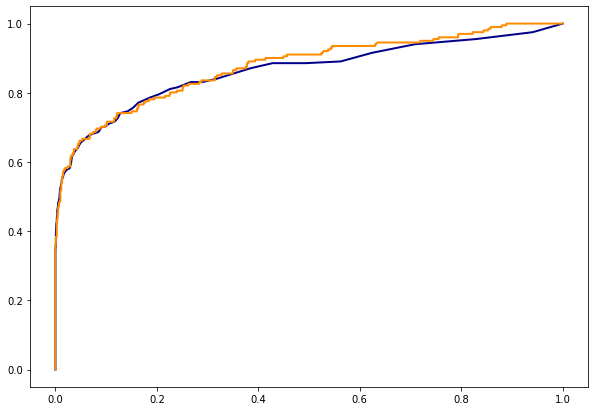

In [55]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# fpr, tpr, thresholds = precision_recall_curve(y_test.values, y_probs[:,1])
fpr, tpr, _= roc_curve(y_test, y_probs[:,1])
fpr_rf, tpr_rf,_ = roc_curve(y_test, y_probs_rf[:,1])
plt.figure(figsize=(10, 7))
roc_auc = auc(fpr, tpr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_rf)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?

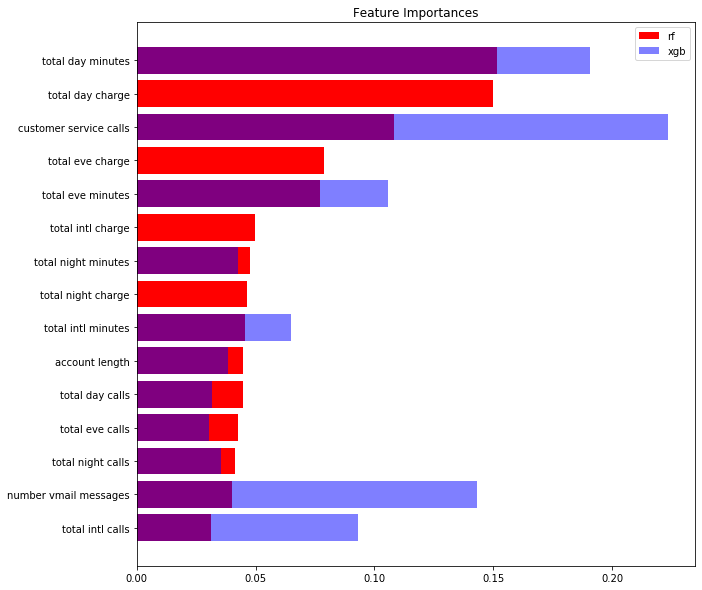

In [61]:
###YOUR CODE###
from xgboost import plot_importance
# plot_importance(xgb)
plt.figure(figsize=(10, 10))

# plt.show()
imp2=xgb.feature_importances_
# print(imp2)
indices2 = np.argsort(imp2)
imp=rf.feature_importances_
indices = np.argsort(imp)

plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='r', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
# >>> plt.xlabel('Relative Importance')
# plt.show()

# plt.title('Feature Importances')
plt.barh(range(len(indices2)), imp2[indices], color='b', align='center', alpha=0.5, )
plt.yticks(range(len(indices2)), [cols[i] for i in indices])
plt.legend(('rf', 'xgb'))
# >>> plt.xlabel('Relative Importance')
plt.show()
# print( [cols[i] for i in indices2])

In Random Forest we bootstrap a set of samples and randomly select a subset of features several times, so we may come up with a situation when we only have features that are of low or even zero importance for the xgboost model, thus even these features will have a non-zero importance for the Random Forest. On the contrary, xgboost works with the whole sample set and with all features, so it is able to prioritize features.

* Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

In [8]:
selector_rfselector_rffrom sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=xgb).fit(X_train, y_train)
selector.transform

<bound method SelectorMixin.transform of SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1, gamma=0,
                                        learning_rate=0.1, max_delta_step=0,
                                        max_depth=3, min_child_weight=1,
                                        missing=None, n_estimators=100,
                                        n_jobs=1, nthread=None,
                                        objective='binary:logistic',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1,
                                        seed=None, silent=None, subsample=1,
                                        verbosity=1),
                max_features=None, norm_order=1, prefit=False, threshold=None)>

In [64]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
recall, precision = {},{}
rec_xgb, prec_xgb=[], []
rec_rf, prec_rf=[], []
for i in range(X_train.shape[1], 0, -1):
    selection = SelectFromModel(xgb, threshold=- np.inf, prefit=True, max_features = i)
    select_X_train = selection.transform(X_train)

    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
       
    prec_xgb.append(precision_score(y_test, y_pred))
    rec_xgb.append(recall_score(y_test, y_pred))
    
    selection_rf = SelectFromModel(rf, threshold=- np.inf, prefit=True, max_features = i)
    select_X_train_rf = selection_rf.transform(X_train)

    selection_model_rf = RandomForestClassifier()
    selection_model_rf.fit(select_X_train_rf, y_train)

    select_X_test_rf = selection_rf.transform(X_test)
    y_pred_rf = selection_model_rf.predict(select_X_test_rf)
    prec_rf.append(precision_score(y_test, y_pred_rf))
    rec_rf.append(recall_score(y_test, y_pred_rf))

# selector_rf = SelectFromModel(estimator=rf).fit(X_train, y_train)
# x_transform = selector_rf.transform(X_test)
# y_pred = rf.predict(x_transform )
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)rec= recall_score(y_test, y_pred)



Accuracy: 85.91%


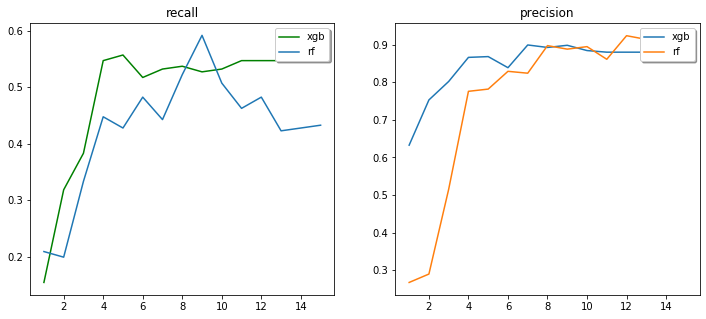

In [95]:
# plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# fig.figure(figsize=(12, 6))
# fig.suptitle('Horizontally stacked subplots')
l1,= ax1.plot([ i for i in range(X_train.shape[1], 0, -1)], rec_xgb, color='g')

l2, =ax1.plot([ i for i in range(X_train.shape[1], 0, -1)], rec_rf)
ax1.legend((l1, l2),("xgb", "rf"),loc='upper right', shadow=True)
ax1.set_title('recall')

ax2.set_title('precision')
l3,= ax2.plot([ i for i in range(X_train.shape[1], 0, -1)], prec_xgb)
l4, = ax2.plot([ i for i in range(X_train.shape[1], 0, -1)], prec_rf)

ax2.legend((l3, l4),("xgb", "rf"),loc='upper right', shadow=True)


# Task 3. Bayesian methods (1 point)

In this task you are asked to compare the performance of the common Ridge Regression with its the parameters chosen using cross-validation technique and Bayesian Ridge Regression. 

In particular, using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html), find the optimal value for the reguralization coefficient in the ridge regression optimization problem formulation. Then train [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) and compare the absolute error and learnt coefficients distribution for both variants and make some conclusions on both methods.

**The task:** 
* Use crossvalidation technique to choose the optimal value of reguralization coefficent for Ridge Regression model. (**Note:** "optimal" value here, means the one that lets the model with this particular parameter value achieve better performance compared to the other variants). 
* Fit Bayesian Ridge Regression model 
* Plot the absolute error historgramms for both models using [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).
* Plot historgrams of coefficients of regression derived from both models (in cross-validation case the coefficients of the best model)
* Compare the two pairs of histrograms. Are they the same or different? Why? What are the prons and cons of both methods?

In [60]:
import sklearn.datasets as dt
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, BayesianRidge
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [61]:
X,y = dt.load_boston(return_X_y=True)
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

In [62]:
###YOUR CODE###
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 1e2, 200, 1e3, 1e4, 1e5]

param_grid = {'alpha' : alphas}
nfolds = 5 # 5-fold cross-validation
# Perform GridSearch
grid_search = GridSearchCV(Ridge(), param_grid, cv=nfolds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50,
                                   100.0, 200, 1000.0, 10000.0, 100000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
# let's call the Ridge Regression model with alpha=200 fit on the train data "ridge"
ridge = grid_search.best_estimator_
y_predict_ridge = ridge.predict(X_test)

In [68]:
print('Best value of the Ridge regression parameter: ', grid_search.best_params_)
print('Score of the best estimator on CV folds: {:.3}'.format(grid_search.best_score_))
print('Score of the best estimator when fit on the whole training set and evaluated on the train data: {:.3}'.format(grid_search.best_estimator_.score(X_train, y_train)))
print('Score of the best estimator when fit on the whole training set and evaluated on the test data: {:.3}'.format(grid_search.best_estimator_.score(X_test, y_test)))
print('Root mean squared error on the test set: {:.3}'.format(np.sqrt(mean_squared_error(y_test, y_predict_ridge))))

Best value of the Ridge regression parameter:  {'alpha': 200}
Score of the best estimator on CV folds: 0.47
Score of the best estimator when fit on the whole training set and evaluated on the train data: 0.691
Score of the best estimator when fit on the whole training set and evaluated on the test data: 0.195
Root mean squared error on the test set: 4.77


In [69]:
# now let's fit the Bayesian Ridge model to the train data
by_ridge = BayesianRidge(normalize=True)
by_ridge.fit(X_train, y_train)
y_predict_byridge = by_ridge.predict(X_test)

In [70]:
print('Score of the Bayesian Ridge model when evaluated on the train data: {:.3}'.format(by_ridge.score(X_train, y_train)))
print('Score of the Bayesian Ridge model when evaluated on the test data: {:.3}'.format(by_ridge.score(X_test, y_test)))
print('Root mean squared error on the test set: {:.3}'.format(np.sqrt(mean_squared_error(y_test, y_predict_byridge))))

Score of the Bayesian Ridge model when evaluated on the train data: 0.733
Score of the Bayesian Ridge model when evaluated on the test data: -0.261
Root mean squared error on the test set: 5.97


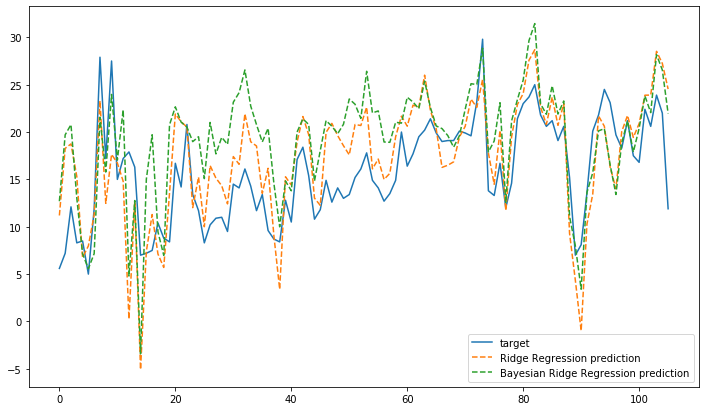

In [71]:

plt.figure(figsize=(12,7))
plt.plot(y_test, label = 'target')
plt.plot(y_predict_ridge, '--', label = 'Ridge Regression prediction')
plt.plot(y_predict_byridge, '--', label = 'Bayesian Ridge Regression prediction')
plt.legend()

Text(0.5, 1.0, 'Absolute error histogram for the Bayesian Ridge Regression model')

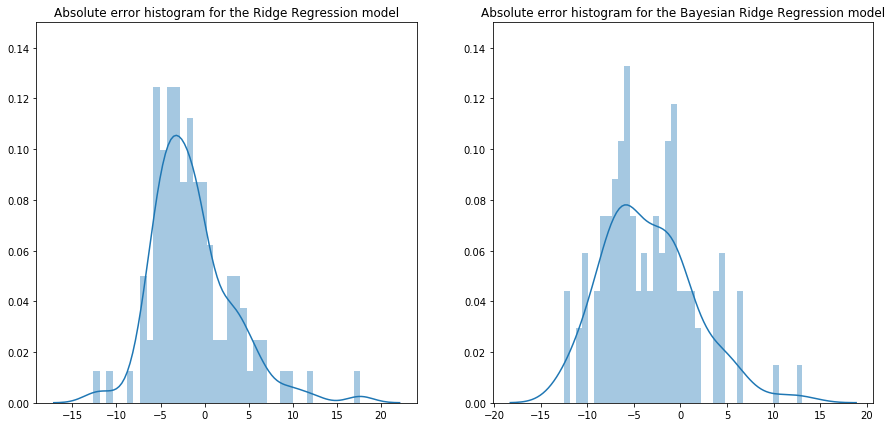

In [123]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot((y_test-y_predict_ridge),bins=40)
plt.ylim([0, 0.15])
plt.title('Absolute error histogram for the Ridge Regression model')
plt.subplot(1,2,2)
plt.ylim([0, 0.15])
sns.distplot((y_test-y_predict_byridge),bins=40);
plt.title('Absolute error histogram for the Bayesian Ridge Regression model')

(-6, 6)

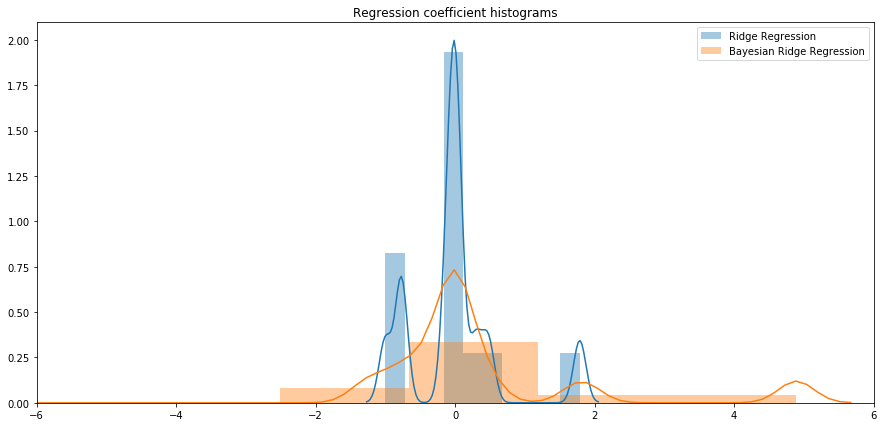

In [124]:
plt.figure(figsize=(15,7))
plt.title('Regression coefficient histograms')
n_bins = 10
h_r = sns.distplot((ridge.coef_),bins=n_bins);
h_byr = sns.distplot((by_ridge.coef_),bins=n_bins);
plt.legend(labels = ['Ridge Regression', 'Bayesian Ridge Regression'])
plt.xlim([-6,6])

#comment here


Both pairs of histograms are different. We can see that the usual Ridge has smaller absolute error and from the second graph we can see that the weights don't have normal distribution, thus our prior distribution for weights does not correspond to data, that's why ridge agression works better in this case.






Pros and cons
Bayesian Ridge  let us use a priori probability and we can get a more accurate model if we know that our weights are distributed normally.



Moreover, We can study posterior distribution of the weights with BR and it allows the ease of interpritation
However, The flaw of BR is that it takes more time to find solution


Ridge regression works faster



# Task 4. Stacking (2 point)

Stacking is another approach to combine several algorithms to get better results.Basically stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The main concept is to learn base models on some set of features then train meta model, which uses the predictions of base models as features. This technique is wiledly used in multiple real case scenarios to get better results. One of the main problem of stacking is, of course, overfitting. To avoid it, the training set is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models, and $ n $ -th for the overall prediction (calculating the meta-factor). In order to train the meta-model, it should receive predictions from the base models for those objects of the training sample on which the meta-model will be trained. 

There are various of stacking approaches$.^{[1]}$ For example, in order, to obtain meta-factors for test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers. If we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained$.^{[2]}$ You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.s. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer [source](quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning). Because they are so similar you can use any of them. 

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  
[2] MLgroup SHAD

**The task:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models(base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml,features e.t.c) and train them.
* Report individual scores on test set for each of the models. As a score use accuracy.
* Train metaclassifier on original datasets features, report score on test.
* Train meta_classifier on those base models. Report the test score (accuracy) in this case.
* Does stacking helped to gain better score?

Enough of theory, let's get back to Practice. Download dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype) and  split it train-test - 60/40.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [86]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore")
# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [87]:
import sklearn
from sklearn import datasets
fc = sklearn.datasets.fetch_covtype()

In [88]:
X, y = fc.data, fc.target

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)

Write meta classifier function.

In [91]:
def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv, use_StackingClassifier=0):
    """
    Meta classifier prediction using stacking. 
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators. 
    :param X_train: numpy array or pandas table, train set.
    :param y_train: numpy array or pandas table, target for train set.
    :param X_test: numpy array or pandas table, test set.
    
    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.
    
    
    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
    
    """
    ###YOUR CODE###
    
    if use_StackingClassifier:
        
        clf = StackingClassifier(estimators=base_clfs, final_estimator=final_classifier, cv=cv, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        meta_train_set, meta_test_set = [], []
        
    else:
        
        # create train and test datasets of size (num_samples, num base models) for the metaclassifier
        meta_train_set = np.zeros((X_train.shape[0], np.size(base_clf,0)))
        meta_test_set = np.zeros((X_test.shape[0], np.size(base_clf,0)))
        
        for idx, bclf_tuple in enumerate(base_clfs):
            
            # bclf_tuple consists of ('classificator's name, classificator itself) - this format is necessary
            # in case of using the StackingClassifier (see above)
            bclf_name = bclf_tuple[0]
            bclf = bclf_tuple[1]
            
            # fit the base classifier on the cv-1 folds and get predictions on the remaining fold 
            # repeat this procedure cv times such that each sample falls into the test set only once
            # (the function cross_val_predict ensures this)
            bclf_train_predict = cross_val_predict(bclf, X_train, y_train, cv=cv)
            meta_train_set[:, idx] = bclf_train_predict
            
            # fit the base classifier on the whole training dataset
            bclf.fit(X_train, y_train)

            # get base classifier's predictions on the test dataset
            bclf_test_predict = bclf.predict(X_test)
            meta_test_set[:,idx] = bclf_test_predict
            
            print('{} was fitted'.format(bclf_name))
        
        print('Fitting the final classifier')
        
        # fit the final classifier on the meta_train_set
        final_classifier.fit(meta_train_set, y_train)
        
        # get final classifier's predictions on the meta_test_set
        y_pred = final_classifier.predict(meta_test_set)
        clf = final_classifier
    
    return y_pred, clf, meta_train_set, meta_test_set

Chose 6 different base models(base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml,features e.t.c) and train them. 

In [92]:
###YOUR CODE###
def fun_return_models():
    DT_shallow = DecisionTreeClassifier(max_depth = 3)
    DT_deep = DecisionTreeClassifier(max_depth = 10)
    RFC = RandomForestClassifier(n_estimators = 3, random_state=1)
    #RFC_large = RandomForestClassifier(n_estimators = 30)
    LR = LogisticRegression()
    KNN = KNeighborsClassifier(n_neighbors = 50)
    LDA = LinearDiscriminantAnalysis()
    
    classifiers = [DT_shallow, DT_deep, RFC, LR, KNN, LDA]
    names = ['Shallow Decision Tree Classifier', 'Deep Decision Tree Classifier', 'Random Forest Classifier, 3 estimators', 'Logistic Regression', 'KNN Classifier, several neighbours', 'Linear Discriminant Analysis']
    base_clf = [(names[i], classifiers[i]) for i in range(np.size(classifiers))]
    
    return base_clf, classifiers, names

Report individual scores on test set. As a score use accuracy.

In [93]:
###YOUR CODE###
base_clf, classifiers, names = fun_return_models()

Train metaclassifier on original datasets features. And report score on test.

In [94]:
print('chance-level accuracy is {:.3}'.format(1/np.size(np.unique(y))))
for i, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    print('accuracy for {} is {:.3}'.format(names[i], accuracy_score(y_test,prediction)))

chance-level accuracy is 0.143
accuracy for Shallow Decision Tree Classifier is 0.676
accuracy for Deep Decision Tree Classifier is 0.777
accuracy for Random Forest Classifier, 3 estimators is 0.902
accuracy for Logistic Regression is 0.618
accuracy for KNN Classifier, several neighbours is 0.891
accuracy for Linear Discriminant Analysis is 0.68


In [95]:
###YOUR CODE###
#metaclassifier = LogisticRegression()
#metaclassifier = KNeighborsClassifier()
metaclassifier = MLPClassifier(max_iter=50)
metaclassifier.fit(X_train, y_train)
meta_predict = metaclassifier.predict(X_test)
print('accuracy for the meta-classifier trained on original dataset features is {:.3}'.format(accuracy_score(y_test,meta_predict)))

accuracy for the meta-classifier trained on original dataset features is 0.715


Train meta_classifier on those base models .

In [96]:
###YOUR CODE###
base_clf, classifiers, names = fun_return_models()
metaclassifier = MLPClassifier(max_iter=50)
meta_predict, meta_clf, meta_train_set, meta_test_set = meta_classifier(base_clf, metaclassifier, X_train, X_test, y_train, 5)


Shallow Decision Tree Classifier was fitted
Deep Decision Tree Classifier was fitted
Random Forest Classifier, 3 estimators was fitted
Logistic Regression was fitted
KNN Classifier, several neighbours was fitted
Linear Discriminant Analysis was fitted
Fitting the final classifier


Report score(accuracy) on test. 

In [97]:
###YOUR CODE###
print('accuracy for the meta-classifier trained on base models is {:.3}'.format(accuracy_score(y_test,meta_predict)))

accuracy for the meta-classifier trained on base models is 0.909


Does stacking helped to gain better score?

Stacking slightly improved the overall accuracy of predicting the test labels. That was achieved by using six base models stacked together. Some of these models had mediocre quality of prediction (< 0.7). The final classifier that was fitted on predictions of the base models was able to learn which predictions are more relevant. The fact that the final classifier performance is better than performances of the individual models suggests that some samples were incorrectly classified by some of the models, but were correctly classified by the other, and vice versa. The stacked classifier took advantage of combining predictions of the base models and this way improved the overall accuracy.

Finally, let's check the performance of the stacking classifier if it is trained not only on the level-1 features (base models' predictions), but on the level-0 features as well (original dataset features X_train).

In [98]:
X_train_new = np.append(X_train, meta_train_set, axis=1)
X_test_new = np.append(X_test, meta_test_set, axis=1)
metaclassifier = MLPClassifier(max_iter=50)
metaclassifier.fit(X_train_new, y_train)
meta_predict_new = metaclassifier.predict(X_test_new)
print('accuracy for the meta-classifier trained on base models and original features is {:.3}'.format(accuracy_score(y_test,meta_predict_new)))

accuracy for the meta-classifier trained on base models and original features is 0.891


It can be seen that the performance of the final classifier is better than if it is trained only on original features, but worse if it is trained only on the level-1 features. Clearly, features added by the base models are the most useful for the prediction. Since the final classifier performs quite poorly on original features, combining them with the level-1 features deteriorates prediction abilities of the model and does not make sense in this case. Thus, it is better to use only the level-1 features for learning the metaclassifier and making predictions.

# Task 5. Gaussian Processes (1 point)

In the following exercise you will need to fit the gaussian process with different kernels on the ```elecricity_conpumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [ ]:
!conda install -c conda-forge gpy

In [79]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [80]:
data = pd.read_csv('elecricity_conpumption_FR.csv')


In [81]:
data.dropna(inplace=True)

In [82]:
y = np.array(data.values)
X = np.array(data.index)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.

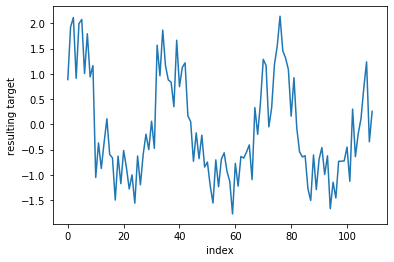

In [85]:
###YOUR CODE###
from sklearn.preprocessing import StandardScaler
scaler=  StandardScaler()
target = scaler.fit_transform(y_train)
y_test_target = scaler.transform(y_test)
plt.ylabel('resulting target')
plt.xlabel('index')
plt.plot(y_test_target)

In [20]:
from GPy.models import GPRegression
from GPy.kern import RBF, Poly, StdPeriodic, White, Linear,PeriodicExponential
from sklearn.metrics import r2_score
import GPy.kern as kern

* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

{'dataplot': [<matplotlib.collections.PathCollection at 0x21985a1d668>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x21984b2a908>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x21985a1dac8>]}

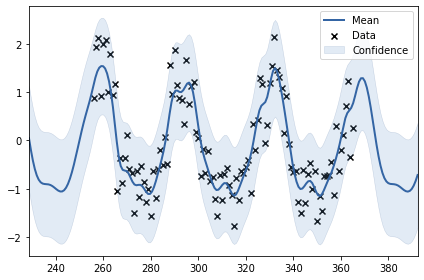

In [21]:
###YOUR CODE###
kernel = StdPeriodic(1,  period=40, lengthscale = 0.4)+RBF(input_dim=1, variance=.3)+StdPeriodic(1,  period=40, lengthscale = 0.4)*RBF(input_dim=1, variance=.3)+White(1)
kernel2 =Poly(input_dim=1, variance=.1)
m1 = GPRegression(X_test, y_test_target, kernel)
# m1.optimize_restarts()
m1.Gaussian_noise.variance.fix(0.1)
m1.optimize()


m1.plot()
# plt.show(fig)

Your answer

In [29]:
predicted = m1.predict(X_test)
mean = np.array(predicted[0])
var = np.array(predicted[1])
std = np.sqrt(var.ravel())

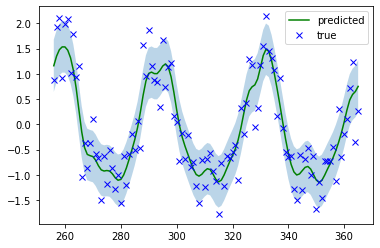

In [36]:
plt.plot(X_test.ravel(), mean, color='green', label='predicted')
plt.plot(X_test.ravel(), y_test_target, 'bx', label='true')
plt.fill_between(X_test.ravel(), mean.ravel() - std, mean.ravel() + std, alpha=0.3)
_ = plt.legend()

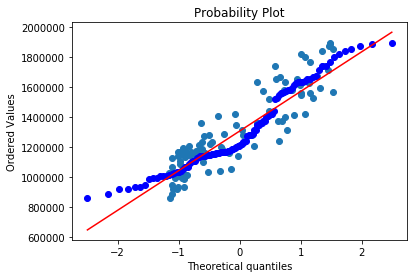

In [50]:
from scipy import stats
plt.scatter(mean, y_test )
# print(mean.shape)
# print(y_test.shape)
a = stats.probplot(y_test.ravel(), plot=plt)

So we can from the plot that the predicted values are close to normal distribution. R_2 score shows rather good performance

In [18]:
from sklearn.metrics import r2_score
r2_score(scaler.transform(y_test), mean)

0.8242177453816601